In [ ]:
# Transformers installation
#! pip install transformers datasets evaluate

In [ ]:
# !pip install datasets
# !pip install transformers



For this assignment, I chose the SetFit/Emotion dataset. It comprises 20,000 rows, with 16,000 rows allocated for training, 2,000 for validation, and 2,000 for testing.


# Data preparation

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
emotions = load_dataset('SetFit/emotion')

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [ ]:
# View 1st 5 rows of training set
emotions["train"][0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3],
 'label_text': ['sadness', 'sadness', 'anger', 'love', 'anger']}

In [ ]:
# 0:sadness
# 1:joy
# 2:love
# 3:anger
# 4:fear
# 5:surprise

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
# Preprocess the dataset
emotions_train = emotions["train"].map(preprocess_function, batched=True)
emotions_validation = emotions["validation"].map(preprocess_function, batched=True)
emotions_test = emotions["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
# id2label={id:label for id,label in enumerate(set(emotions["train"]['label_text']))}

# label2id={label:id for id,label in enumerate(set(emotions["train"]['label_text']))}

# label2id

id2label= {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label2id= {"sadness": 0, "joy": 1, "love": 2, "anger": 3, "fear": 4, "surprise": 5}

# Model tuning

In [ ]:
# Define training parameters
batch_size = 8
num_epochs = 5
total_train_steps = len(emotions_train) // batch_size * num_epochs

# Create optimizer and learning rate schedule
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:

# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Prepare training and validation datasets
tf_train_set = model.prepare_tf_dataset(
    emotions_train,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)

tf_validation_set = model.prepare_tf_dataset(
    emotions_validation,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

# Compile the model
model.compile(optimizer=optimizer, metrics=["accuracy"])

# Define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=4, callbacks=[callback])

Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2000/2000 [==============================] - 205s 78ms/step - loss: 0.4127 - accuracy: 0.8579 - val_loss: 0.1806 - val_accuracy: 0.9290
Epoch 2/4
2000/2000 [==============================] - 137s 68ms/step - loss: 0.1287 - accuracy: 0.9433 - val_loss: 0.1301 - val_accuracy: 0.9415
Epoch 3/4
2000/2000 [==============================] - 137s 68ms/step - loss: 0.0959 - accuracy: 0.9523 - val_loss: 0.1259 - val_accuracy: 0.9445
Epoch 4/4
2000/2000 [==============================] - 131s 65ms/step - loss: 0.0740 - accuracy: 0.9636 - val_loss: 0.1264 - val_accuracy: 0.9420


**Inference**

In [ ]:
text = "i was feeling as heartbroken as im sure katniss was"

from transformers import pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
classifier(text)

[{'label': 'sadness', 'score': 0.9985620379447937}]

# Model Evaluation

In [ ]:
# Shuffle and select the first 2000 examples from the test set
emotions['test'] = emotions['test'].shuffle().select(range(2000))

# Define a function to get predictions for a batch of test examples
def get_predictions(batch):
    # Apply the classifier to the batch of texts
    predictions = classifier(batch['text'], truncation=True)
    # Extract and return the predicted labels (use label2id to map the labels to ids)
    return {'prediction': [label2id[pred['label']] for pred in predictions]}

# Apply the get_predictions function to all batches in the test set
emotions_test = emotions['test'].map(get_predictions, batched=True, batch_size=16)

# Extract the predicted labels
predictions = emotions_test['prediction']

# Get the true labels
true_labels = emotions['test']['label']


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

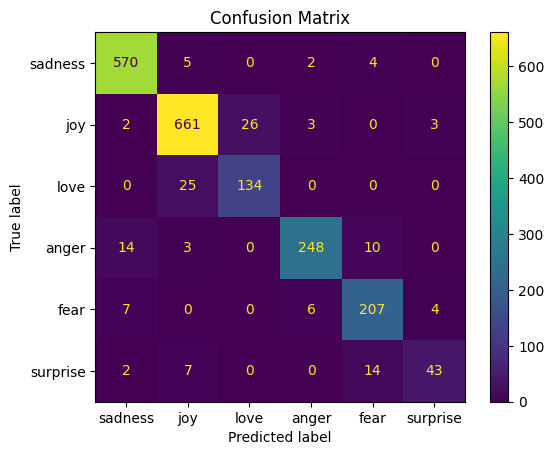

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Define class labels with corresponding emotions
text_labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(text_labels.values()))
disp.plot()
plt.title('Confusion Matrix')
plt.show()


Convert numbers to percentage.

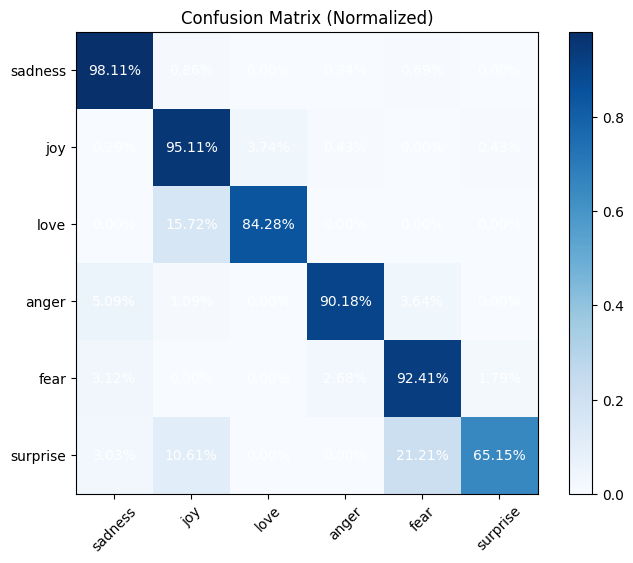

In [ ]:
import numpy as np

# Normalize confusion matrix to convert to percentages
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


cmap = plt.cm.Blues

# Plot the confusion matrix using imshow
plt.figure(figsize=(8, 6))
plt.imshow(normalized_conf_matrix, cmap=cmap)
plt.colorbar()

for (i, j), value in np.ndenumerate(normalized_conf_matrix): # Generate AI
  plt.text(j, i, "{:0.2f}%".format(value * 100), color='white', ha='center', va='center', fontsize=10) # Generate AI

plt.xticks(range(len(text_labels)), list(text_labels.values()), rotation=45)
plt.yticks(range(len(text_labels)), list(text_labels.values()))
plt.title('Confusion Matrix (Normalized)')
plt.show()

**Total accuracy:**

In [ ]:
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.15%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score
precision, recall, f1_score,_ = precision_recall_fscore_support(true_labels, predictions, average=None)

# Print the precision, recall, F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: [0.95798319 0.94293866 0.8375     0.95752896 0.88085106 0.86      ]
Recall: [0.98106713 0.95107914 0.8427673  0.90181818 0.92410714 0.65151515]
F1-score: [0.96938776 0.9469914  0.84012539 0.92883895 0.90196078 0.74137931]


Print the same result in tabular format.

In [ ]:
print("Emotions\tPrecision\tRecall\t\tF1-score")
print("---------------------------------------------------------")
for i in range(len(precision)):
    emotion = text_labels[i]
    print(f"{emotion.ljust(10)}\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1_score[i]:.4f}\t")

Emotions	Precision	Recall		F1-score
---------------------------------------------------------
sadness   	0.9580		0.9811		0.9694	
joy       	0.9429		0.9511		0.9470	
love      	0.8375		0.8428		0.8401	
anger     	0.9575		0.9018		0.9288	
fear      	0.8809		0.9241		0.9020	
surprise  	0.8600		0.6515		0.7414	


Note: Mostly follow module 9 lab1.

Reference  links:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

Command to use: Loop through each cell and display percentage value